### Installing missing libraries



In [0]:
!pip install tpot
!pip install imblearn
!pip install xgboost

     |████████████████████████████████| 81kB 31.2MB/s 
     |████████████████████████████████| 153kB 60.9MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=82e04d26d9a1dce9449bf27a02d2a176e36f361e2db07145ccb03a19f09c9a25
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


### Imports

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import numpy as np
import tpot as tp
import imblearn
from collections import Counter
from tpot import TPOTClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN 
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
sns.set()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Load data into pandas dataframe

In [24]:
bc_data = pd.read_csv('/content/drive/My Drive/flatiron/mod5proj/breast-cancer-wisconsin.data',names=['id_number','Clump Thickness', 'Uniformity of Cell Size',
                 'Uniformity of Cell Shape', 'Marginal Adhesion', 
                 'Single Epithelial Cell Size','Bare Nuclei',
                 'Bland Chromatin','Normal Nucleoli','Mitosis','Class'])
bc_data.head()

,id_number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitosis,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### visualize the target class numbers to check for balance of classifier column

Benign: 458
Malignant: 241
Proportion: 1.9 : 1


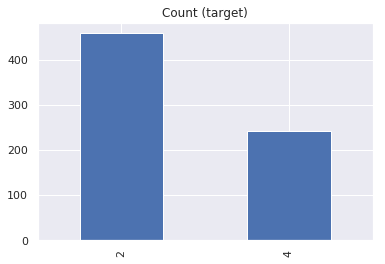

In [25]:
target_count = bc_data.Class.value_counts()
print('Benign:', target_count[2])
print('Malignant:', target_count[4])
print('Proportion:', round(target_count[2] / target_count[4], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Check data types in the dataframe

In [0]:
bc_data.dtypes

id_number                       int64
Clump Thickness                 int64
Uniformity of Cell Size         int64
Uniformity of Cell Shape        int64
Marginal Adhesion               int64
Single Epithelial Cell Size     int64
Bare Nuclei                    object
Bland Chromatin                 int64
Normal Nucleoli                 int64
Mitosis                         int64
Class                           int64
dtype: object

create a target array and remove it from the data table

get dummies for bare nuclei

In [0]:
bc_data_with_dummies = pd.get_dummies(bc_data)

In [0]:
target = bc_data_with_dummies['Class']
bc_data_with_dummies.drop('Class', axis = 1, inplace = True)
bc_data_with_dummies.head()

,id_number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitosis,Bare Nuclei_1,Bare Nuclei_10,Bare Nuclei_2,Bare Nuclei_3,Bare Nuclei_4,Bare Nuclei_5,Bare Nuclei_6,Bare Nuclei_7,Bare Nuclei_8,Bare Nuclei_9,Bare Nuclei_?
0,1000025,5,1,1,1,2,3,1,1,1,0,0,0,0,0,0,0,0,0,0
1,1002945,5,4,4,5,7,3,2,1,0,1,0,0,0,0,0,0,0,0,0
2,1015425,3,1,1,1,2,3,1,1,0,0,1,0,0,0,0,0,0,0,0
3,1016277,6,8,8,1,3,3,7,1,0,0,0,0,1,0,0,0,0,0,0
4,1017023,4,1,1,3,2,3,1,1,1,0,0,0,0,0,0,0,0,0,0


set index to id number

In [0]:
bc_data_with_dummies.set_index('id_number', inplace = True)

In [0]:
bc_data_with_dummies.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitosis,Bare Nuclei_1,Bare Nuclei_10,Bare Nuclei_2,Bare Nuclei_3,Bare Nuclei_4,Bare Nuclei_5,Bare Nuclei_6,Bare Nuclei_7,Bare Nuclei_8,Bare Nuclei_9,Bare Nuclei_?
id_number,,,,,,,,,,,,,,,,,,,
1000025,5,1,1,1,2,3,1,1,1,0,0,0,0,0,0,0,0,0,0
1002945,5,4,4,5,7,3,2,1,0,1,0,0,0,0,0,0,0,0,0
1015425,3,1,1,1,2,3,1,1,0,0,1,0,0,0,0,0,0,0,0
1016277,6,8,8,1,3,3,7,1,0,0,0,0,1,0,0,0,0,0,0
1017023,4,1,1,3,2,3,1,1,1,0,0,0,0,0,0,0,0,0,0


### Split data into training and testing sets

In [0]:
features = bc_data_with_dummies

X = bc_data_with_dummies
y = target

features_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.25, random_state=1)

### testing data with xgboost to see what the accuracy score is without balancing the data first

In [20]:

model = XGBClassifier()
model.fit(features_train, target_train)
target_pred = model.predict(features_test)

accuracy = accuracy_score(target_test, target_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.71%


confusion matrix

Confusion matrix:
 [[116   2]
 [  2  55]]


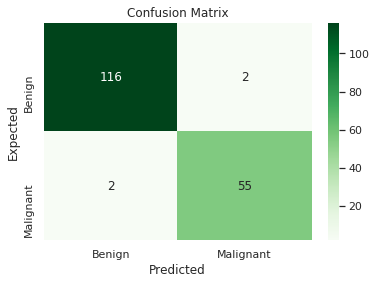

In [0]:
conf_mat = confusion_matrix(y_true=target_test, y_pred=target_pred)
print('Confusion matrix:\n', conf_mat)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g', cmap = 'Greens'); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Expected'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Malignant']); ax.yaxis.set_ticklabels(['Benign', 'Malignant']);

Function to plot PCA and resampling results

In [0]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

PCA to visualize the classes

Explained variation per principal component: [6.94177517e-01 7.41665893e-02 5.95442911e-02 4.83453168e-02
 4.38951903e-02 3.08025096e-02 2.75249835e-02 1.41342083e-02
 2.42811574e-03 1.63138293e-03 7.15950993e-04 7.04635562e-04
 5.40161733e-04 4.61766684e-04 3.92952297e-04 2.32516495e-04
 1.99204686e-04 1.02707021e-04 7.63567344e-35]


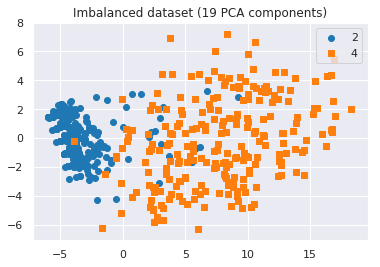

In [22]:
pca = PCA(n_components=19)
pca_result = pca.fit_transform(bc_data_with_dummies)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plot_2d_space(pca_result, y, 'Imbalanced dataset (19 PCA components)')

### Testing different resampling methods

Testing SMOTE oversampling method which generates new samples in the smaller sample from its nearest neighbors

[(2, 340), (4, 340)]


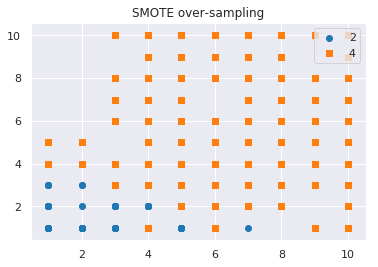

In [0]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(features_train, target_train)
print(sorted(Counter(y_sm).items()))

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

Testing SMOTE and Tomek combination over and undersampling method

[(2, 339), (4, 339)]


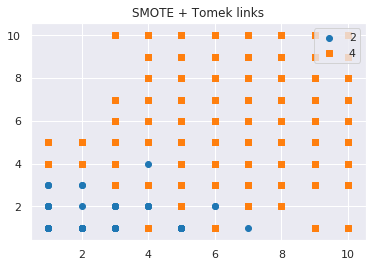

In [0]:
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(features_train, target_train)
print(sorted(Counter(y_smt).items()))

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

Testing SMOTE + NN combination over and under sampling method

[(2, 316), (4, 306)]


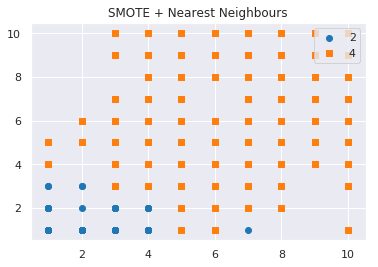

In [0]:
smote_enn = SMOTEENN(random_state=0)
X_smenn, y_smenn = smote_enn.fit_resample(features_train, target_train)
print(sorted(Counter(y_smenn).items()))

plot_2d_space(X_smenn, y_smenn, 'SMOTE + Nearest Neighbours')

 Testing ADASYN Over-sampling

[(2, 340), (4, 327)]


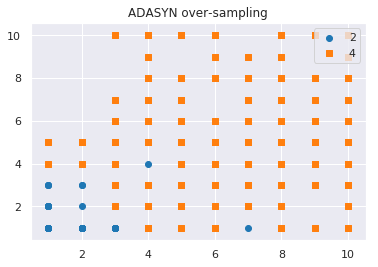

In [28]:
from imblearn.over_sampling import ADASYN 
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(features_train,target_train)
print(sorted(Counter(y_ada).items()))

plot_2d_space(X_ada,y_ada, 'ADASYN over-sampling')

### TPOT

In [0]:
tpot = TPOTClassifier(generations=60, population_size= 60, cv = 10, scoring='roc_auc', verbosity= 2, n_jobs= 1)
tpot.fit(X_ada,y_ada)

Generation 1 - Current best internal CV score: 0.9924298128342246
Generation 2 - Current best internal CV score: 0.9926776960784315
Generation 3 - Current best internal CV score: 0.9926776960784315
Generation 4 - Current best internal CV score: 0.9930091354723707
Generation 5 - Current best internal CV score: 0.9942513368983956
Generation 6 - Current best internal CV score: 0.9953375668449198
Generation 7 - Current best internal CV score: 0.9953375668449198
Generation 8 - Current best internal CV score: 0.9955241755793226
Generation 9 - Current best internal CV score: 0.9955241755793226
Generation 10 - Current best internal CV score: 0.9955241755793226
Generation 11 - Current best internal CV score: 0.9955241755793226
Generation 12 - Current best internal CV score: 0.9955241755793226
Generation 13 - Current best internal CV score: 0.9955241755793226
Generation 14 - Current best internal CV score: 0.9955241755793226
Generation 15 - Current best internal CV score: 0.9955241755793226
Gene

In [30]:
print(tpot.score(features_test,target_test))

0.9986619090098126


In [0]:
tpot.export('tpot_bc_pipeline_ada.py')

### using the chosen model from tpot

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

In [0]:
extratrees = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.5, min_samples_leaf=1, min_samples_split=18, n_estimators=100)
extratrees.fit(X_ada,y_ada)

extratrees_pred = extratrees.predict(features_test)

accuracy = accuracy_score(target_test, extratrees_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.14%


Confusion matrix:
 [[114   4]
 [  1  56]]


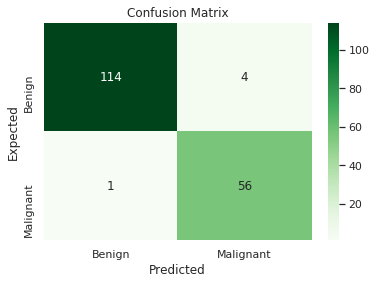

In [0]:
conf_mat = confusion_matrix(y_true=target_test, y_pred=extratrees_pred)
print('Confusion matrix:\n', conf_mat)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g', cmap = 'Greens'); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Expected'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Malignant']); ax.yaxis.set_ticklabels(['Benign', 'Malignant']);

In [0]:
def plot_feature_importances(model):
    n_features = features_train.shape[1]
    plt.figure(figsize=(8,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), features_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

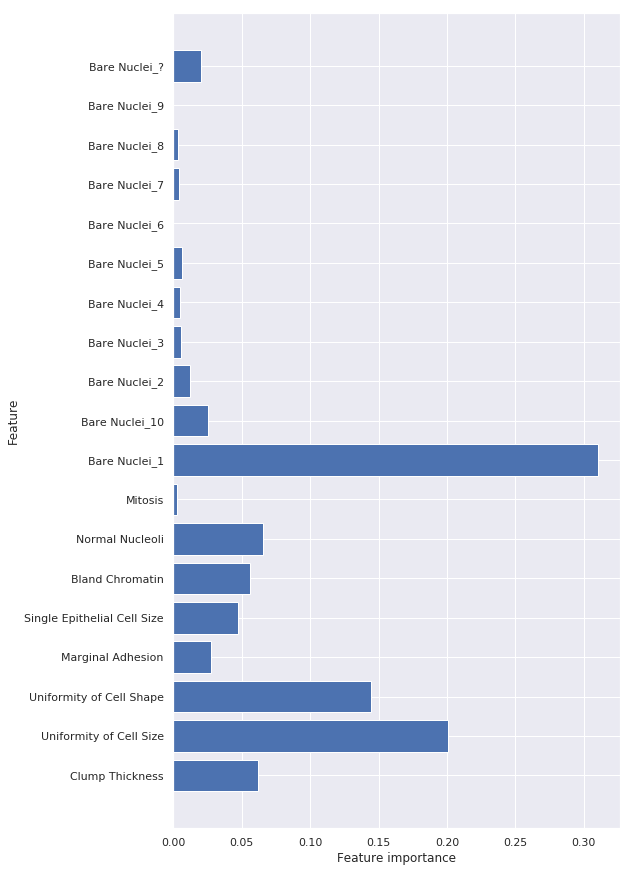

In [0]:
plot_feature_importances(extratrees)

In [0]:
print(classification_report(target_test,extratrees_pred))

              precision    recall  f1-score   support

           2       0.99      0.97      0.98       118
           4       0.93      0.98      0.96        57

    accuracy                           0.97       175
   macro avg       0.96      0.97      0.97       175
weighted avg       0.97      0.97      0.97       175



### visualizing one of the trees 

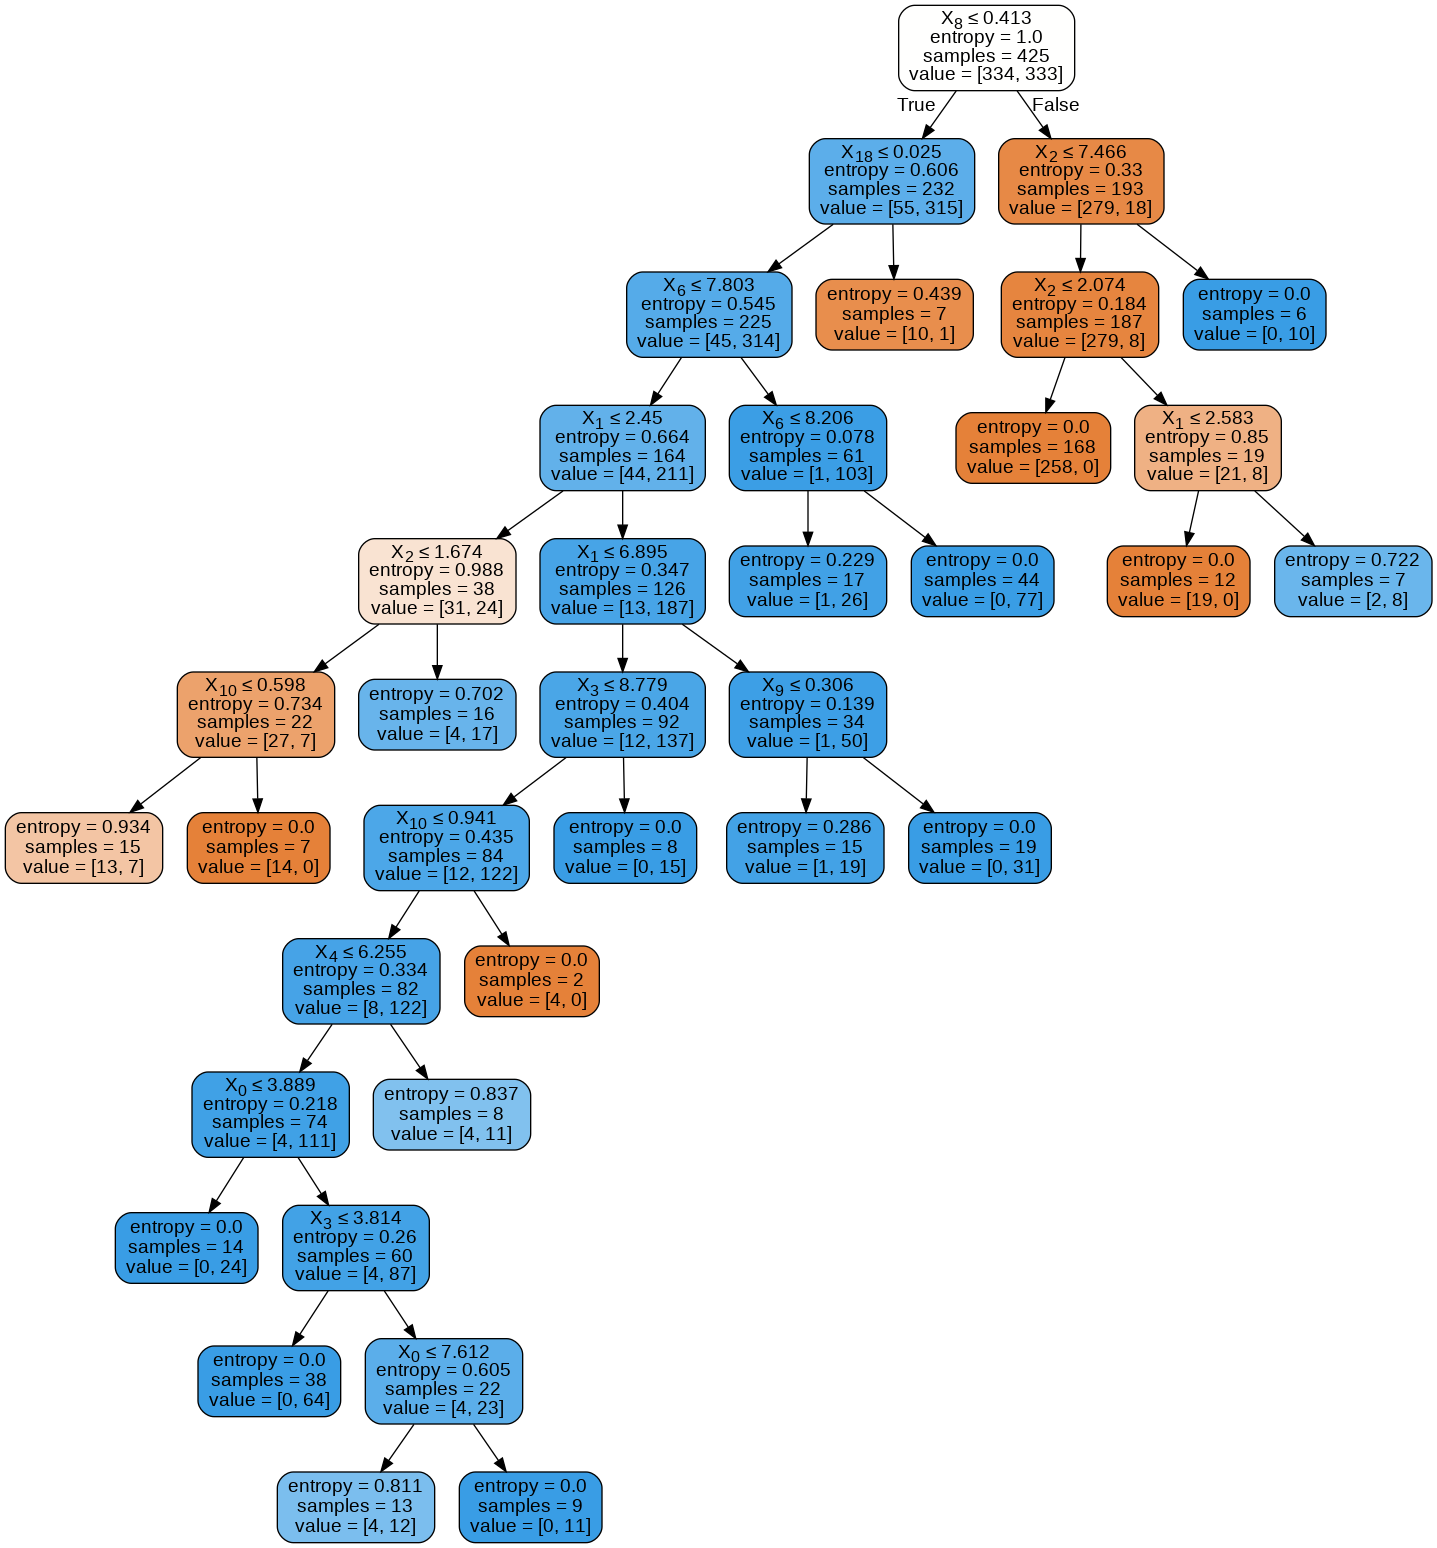

In [0]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(extratrees.estimators_[1], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())